In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


This notebook contains code to reproduce the following from Mitra, et al.:

**Supplementary Figures:**
* Supplementary Figure 1: Distribution of number of mutations to new alleles

**Statistics:**
* How many of the mutations result in common >1% alleles?

In [2]:
# Input mutation results
MUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.final_qc_mutations.tab"

# Make editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Other input data
ANNOTFILE = "/storage/mgymrek/ssc-denovos/annotations/hg38_gangstr_MasterAnnotation.bed"
AFREQFILE = "/storage/mgymrek/ssc-denovos/allele-freqs/SSC_merged_allele_counts.tab"
HETFILE = "/storage/mgymrek/ssc-denovos/allele-freqs/SSC_merged_het.tab"

# Output path info
OUTDIR = "pdfs/"

In [3]:
# Load main mutations data
alldata = pd.read_csv(MUTFILE, sep="\t")

# Load annotation info
annot = pd.read_csv(ANNOTFILE, sep="\t")

# Set up fields
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)
alldata["chrom"] = alldata["chrom"].apply(GetChrom)
annot = annot[annot["chrom"].apply(lambda x: x not in ["X","chrX","Y","chrY"])]
annot["chrom"] = annot["chrom"].apply(GetChrom)
annot["pos"] = annot["start"]

# Merge
adata = pd.merge(alldata, annot, on=["chrom","pos"])
adata["newallele_bp"] = adata.apply(lambda x: (x["newallele"]-(x["end"]-x["pos"]+1)/(x["period_x"]))*x["period_x"], 1)

/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)

het = pd.read_csv(HETFILE, sep="\t")
het["chrom"] = het["chrom"].apply(GetChrom)

afreq = pd.read_csv(AFREQFILE, sep="\t")
afreq.columns = ["chrom","pos","newallele","count"]
afreq["chrom"] = afreq["chrom"].apply(GetChrom)
afreq = pd.merge(afreq, het[["chrom","pos","total"]], on=["chrom","pos"])
afreq["freq"] = afreq.apply(lambda x: float(x["count"])/x["total"], 1)

fdata = pd.merge(adata, afreq, on=["chrom","pos","newallele"], how="left")
fdata.ix[np.isnan(fdata["freq"]),"freq"] = 0
fdata.ix[np.isnan(fdata["count"]),"count"] = 0

/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


Fraction common: 0.844099888792496


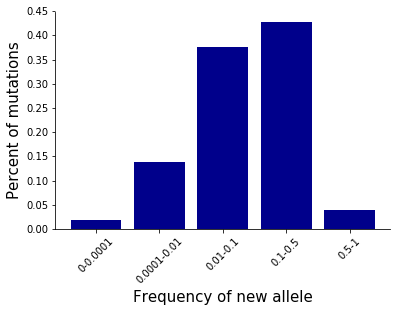

In [5]:
bins = [0, 0.0001, 0.01, 0.1, 0.5, 1]
counts = []
labels = []
for i in range(len(bins)-1):
    lb = bins[i]
    ub = bins[i+1]
    count = fdata[(fdata["freq"]>=lb) & (fdata["freq"]<=ub)].shape[0]
    counts.append(count*1.0/fdata.shape[0]);
    labels.append("%s-%s"%(lb, ub))
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(len(bins)-1), counts, color="darkblue");

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');

ax.set_xticks([item for item in np.arange(len(bins)-1)])
ax.set_xticklabels(labels, rotation=45);
ax.set_xlabel("Frequency of new allele", size=15)
ax.set_ylabel("Percent of mutations", size=15);

# How many are common >1%?
print("Fraction common: %s"%sum(counts[2:]))

fig.savefig(os.path.join(OUTDIR, "SuppFigure_AlleleFreqMutations.pdf"));